In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import glob

from math import *

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable

from torchvision.datasets import MNIST
from IPython import display
import time

from PIL import Image

import copy

def tovar(x):
    return torch.cuda.FloatTensor(x)

def toivar(x):
    return torch.cuda.LongTensor(x)

## Load MNIST dataset

In [4]:
mnist = MNIST(root="data/", train=True)

mnist_x = []

i = 0
for x,y in mnist:
    x = np.array(x)/255.0
    mnist_x.append(x)

mnist_x = np.array(mnist_x)
print(mnist_x.shape)

# Establishes chance-level performance on the mean-squared error reconstruction
chance_level = np.mean((mnist_x - mnist_x.mean())**2)

(60000, 28, 28)


## Network architecture specification

An important point about how this is set up is that the batch dimension of the network corresponds to different latent Gaussian noise vectors $\vec{z}$, whereas the batch dimension of the data corresponds to different samples from the data distribution. So despite both using the first axis of the tensor, they don't directly correspond to eachother.

When calculating the loss, these are unsqueezed into different axes and broadcast, so that we calculate the loss comparing each element of the data batch with each generated sample.

One could also implement this as an extra trailing dimension (with kernel size 1 in that axis for all the convolution operations), but we found that to be less memory efficient.

In [5]:
# This is the basic upscale and convolve block that we will use for the generator

class Conv(nn.Module):
    def __init__(self, NI, NO):
        super(Conv,self).__init__()
        
        self.c1 = nn.Conv2d(NI, NO, 3, padding=1)
        nn.init.orthogonal_(self.c1.weight, gain=sqrt(2))
        self.c2 = nn.Conv2d(NO, NO, 3, padding=1)
        nn.init.orthogonal_(self.c2.weight, gain=sqrt(2))
    
    def forward(self, x):
        z = F.interpolate(x, scale_factor=2)
        z = F.relu(self.c1(z))
        z = F.relu(self.c2(z))
        
        return z

# This is the extreme value loss network for generating images.
# For MNIST, we generate up to 32x32 and then take a center crop.

# The network has two branches - a convolutional branch in which output images are generated and refined scale 
# by scale, and a dense network branch which calculates the likelihood to associate with a particular noise sample.
# We experiment with the case in which these branches diverge immediately from the input, but one could in
# principle have a shared stack of layers before splitting, or even use a discriminator-like architecture to 
# assign post-hoc likelihood after the image has been generated.

class EVL(nn.Module):
    def __init__(self, noise_d = 16):
        super(EVL,self).__init__()
        
        self.c1 = Conv(noise_d, 512)
        self.c2 = Conv(512, 256)
        self.c3 = Conv(256, 128)
        self.c4 = Conv(128, 128)
        self.c5 = Conv(128, 64)
        self.c6 = nn.Conv2d(64, 1, 3, padding=1)
        
        self.l1 = nn.Linear(noise_d, 256)
        nn.init.orthogonal_(self.l1.weight, gain=sqrt(2))
        self.l2 = nn.Linear(256, 256)
        nn.init.orthogonal_(self.l2.weight, gain=sqrt(2))
        self.l3 = nn.Linear(256, 256)
        nn.init.orthogonal_(self.l3.weight, gain=sqrt(2))
        self.l4 = nn.Linear(256, 256)
        nn.init.orthogonal_(self.l4.weight, gain=sqrt(2))
        self.l5 = nn.Linear(256, 1)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        
        self.optim = torch.optim.RMSprop(self.parameters(), lr=1e-4)
        self.schedule = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.95)
        
    def forward(self, x):
        z = self.c1(x)
        z = self.c2(z)
        z = self.c3(z)
        z = self.c4(z)
        z = self.c5(z)        
        z = self.c6(z)
        z = z[:,:,2:30,2:30]
        
        z2 = F.relu(self.l1(x.squeeze(3).squeeze(2)))
        z2 = F.relu(self.l2(z2))
        z2 = F.relu(self.l3(z2))
        z2 = F.relu(self.l4(z2))
        p = F.log_softmax(self.l5(z2)[:,0], dim=0)
        
        return z, p

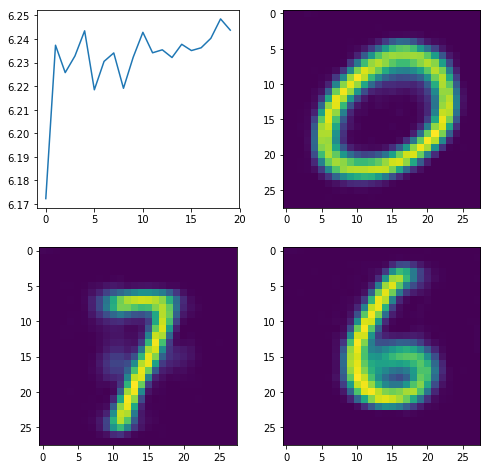

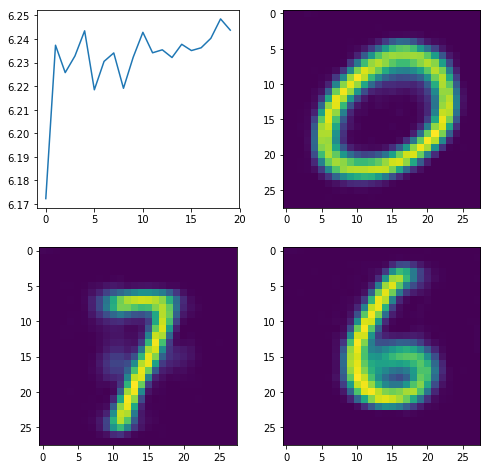

In [6]:
# Instantiate and train the network
NOISE_D = 2
BS = 50
SAMPLES = 512

torch.cuda.manual_seed_all(12345)
net = EVL(noise_d=NOISE_D).cuda()

errs = []

for epoch in range(20):
    err = []
    for i in range(mnist_x.shape[0]//BS):
        net.zero_grad()
        y = tovar(mnist_x[i*BS:i*BS+BS]).unsqueeze(3)
        
        x = torch.zeros(SAMPLES, NOISE_D, 1, 1).cuda()
        x.normal_()
        
        z,p = net.forward(x)
        z = z.squeeze(1).unsqueeze(3).transpose(3,0)
        
        loss = ((z-y)**2).mean(2).mean(1)
        
        mloss, midx = torch.min(loss,1)
        
        mloss = torch.mean(mloss)
        
        ploss = -torch.mean(p[midx])
                
        loss = mloss + ploss
        loss.backward()
        
        net.optim.step()
        
        err.append(loss.cpu().detach().item())
    
    net.schedule.step()
    errs.append(np.mean(err))
    
    plt.clf()
    
    plt.subplot(2,2,1)
    plt.plot(errs)
    
    z = z.cpu().detach().numpy()
    
    for i in range(3):
        plt.subplot(2,2,2+i)
        im = np.clip(z[0,:,:,i],0,1)
        
        plt.imshow(im)
    
    plt.gcf().set_size_inches((8,8))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

## Generate examples from the network

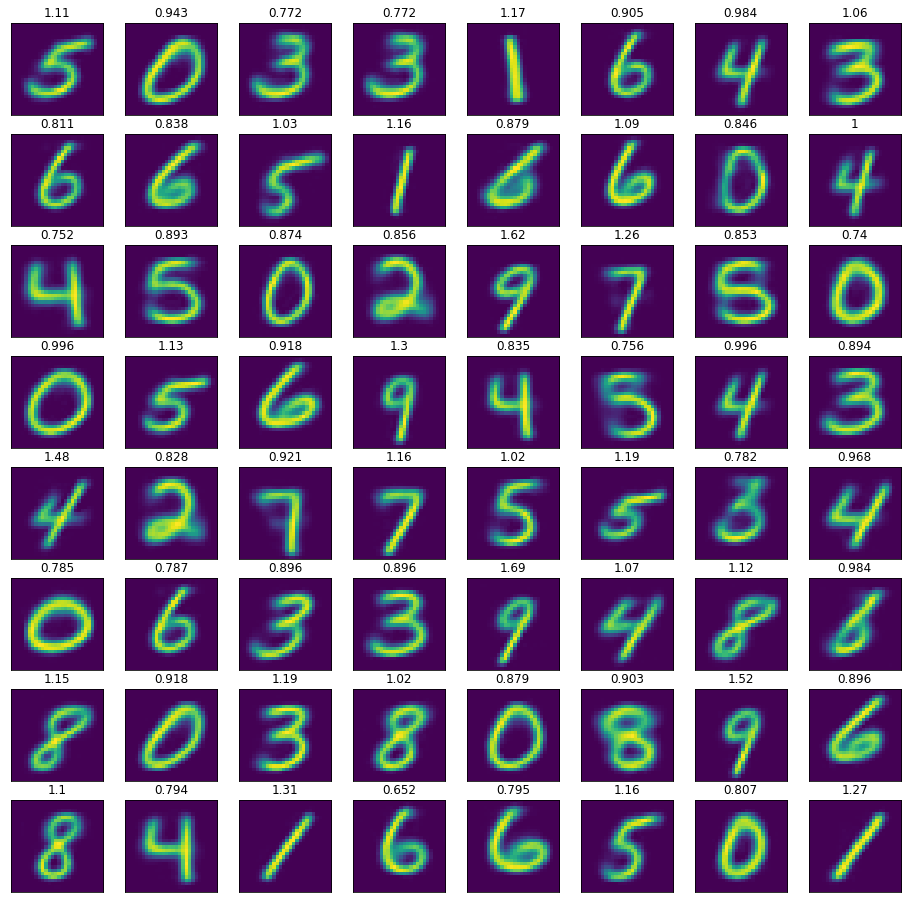

In [7]:
torch.cuda.manual_seed_all(12345)

x = torch.zeros(64, NOISE_D, 1, 1).cuda()
x.normal_()

z,p = net.forward(x)
z = z.squeeze(1)
z = z.cpu().detach().numpy()
p = p.cpu().detach().numpy()

plt.gcf().set_facecolor('white')

for i in range(64):
    plt.subplot(8,8,1+i)
    plt.title("%.3g" % (64*exp(p[i])))
    im = np.clip(z[i,:,:],0,1)        
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)    
    
plt.gcf().set_size_inches((16,16))
plt.savefig("mnist_samples_wide.pdf")

## Generate interpolates

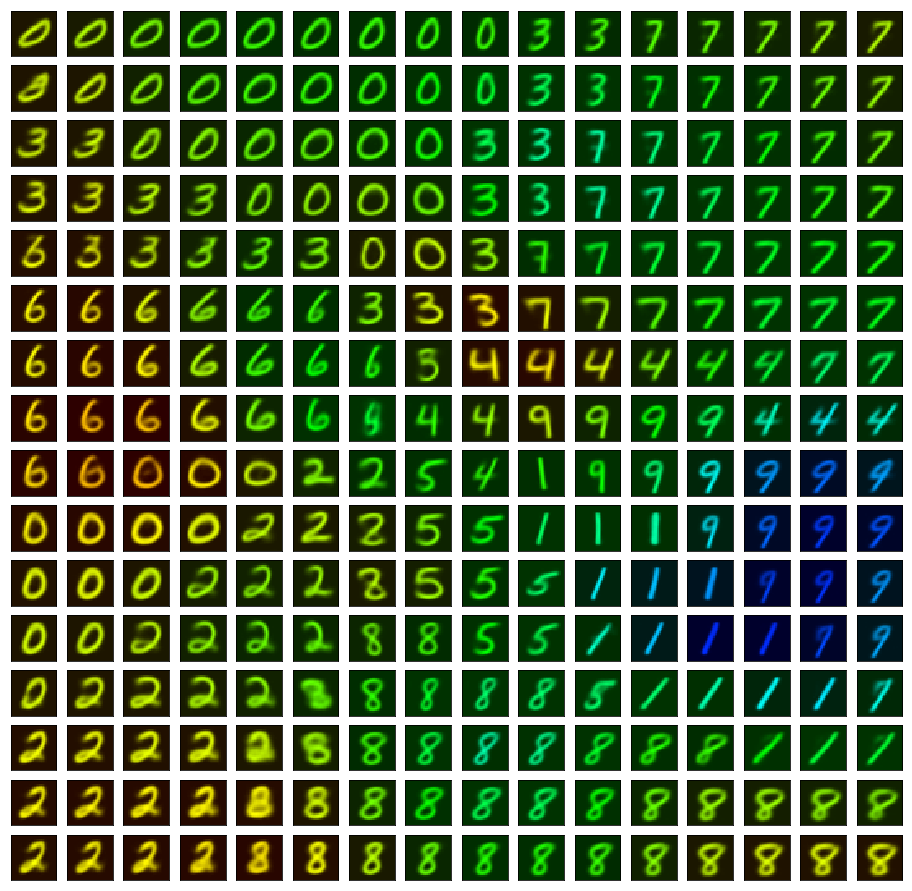

In [8]:
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(12345)

x0 = np.array([-2,-2]).reshape((1,NOISE_D,1,1))
x1 = np.array([2,-2]).reshape((1,NOISE_D,1,1))
y0 = np.array([-2,2]).reshape((1,NOISE_D,1,1))
y1 = np.array([2,2]).reshape((1,NOISE_D,1,1))

u,v = np.meshgrid(np.arange(16)/15.0, np.arange(16)/15.0)
u = u.reshape((16*16,1,1,1))
v = v.reshape((16*16,1,1,1))

x = tovar(x0*u*v+x1*(1-u)*v + y0*u*(1-v) + y1*(1-u)*(1-v))

z,p = net.forward(x)
z = z.squeeze(1)
z = z.cpu().detach().numpy()
p = p.cpu().detach().numpy()

plt.gcf().set_facecolor('white')

x0 = x.cpu().detach().numpy().reshape((16*16, 2))

for i in range(256):
    proba = 256*exp(p[i])-0.5
    theta = pi*proba
    
    c0 = np.clip(np.array([cos(theta)*0.2,cos(theta-2*pi/3)*0.2,cos(theta-4*pi/3)*0.2]),0,1)
    c1 = np.clip(np.array([cos(theta+0.3)+0.5,cos(theta-2*pi/3+0.3)+0.5,cos(theta-4*pi/3+0.3)+0.5]),0,1)
    
    cm = LinearSegmentedColormap.from_list(
        "PointCM", [c0,c1], N=256)
    
    plt.subplot(16,16,1+i)
    im = np.clip(z[i,:,:],0,1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im,cmap=cm)
    
plt.gcf().set_size_inches((16,16))
plt.savefig("mnist_interpolate_wide.pdf")

In [9]:
torch.save(net.state_dict(), open("mnist.pth","wb"))